In [27]:
import os
os.chdir('/home/jovyan/wav2betterlip')
import torch
from torch.utils.data import Dataset
from skimage import io as skimageio
from tqdm.auto import tqdm
from utils.spath import *
from utils.sdraw import *
from utils.smath import *
from utils.basel import Basel
!pwd
!pip install wandb
import pandas as pd
import wandb
from sklearn.utils import shuffle


/home/jovyan/wav2betterlip


In [2]:
wandb.login(key="4a8815956332859275d8c3499568ad5f3e4ace70")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: misterbuilder (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


True

In [32]:
# device = "cuda:0"
# basel = Basel(device="cuda:0")
basel_cpu = Basel(device="cpu")

In [2]:
df=pd.read_csv('workspace/data.csv').reset_index(drop=True)


In [64]:
def smart_plot(faces, titles=None,lines = None, color = None,xlim=None,ylim=None):
    if type(faces) is not list:
        faces = [faces]
    if titles and type(titles) is not list:
        titles = [titles]

    face_count = len(faces)
    width = 3 if face_count >= 3 else face_count
    height = int(face_count / 3) + 1
    fig = plt.figure(figsize=(10*width, 10*height), dpi=100, )


    if len(faces[0][0]) == 3:
        for idx, face in enumerate(faces):
            ax = fig.add_subplot(height, width, idx + 1, projection='3d')
            surf = ax.scatter(face[:, 0],
                              face[:, 1],
                              face[:, 2],
                              c='cyan',
                              alpha=1.0,
                              edgecolor='b')

            if lines:
                for line in lines:
                    ax.plot3D(face[line, 0],
                              face[line, 1],
                              face[line, 2], color='blue')

            for i, d in enumerate(face):
                plt.annotate(str(i), (face[i, 0], face[i, 1]),clip_on=True)

            ax.view_init(elev=90., azim=90.)
            ax.set_xlim(ax.get_xlim()[::-1]) if not xlim else ax.set_xlim(xlim)
            ax.set_ylim(ax.get_ylim()[::-1]) if not ylim else ax.set_ylim(ylim)



            title = idx if type(titles) is not list else titles[idx]
            ax.title.set_text(title)
            
    if len(faces[0][0]) == 2:
        for idx, face in enumerate(faces):
            ax = fig.add_subplot(height, width, idx + 1)
            ax.scatter(face[:, 0],
                              face[:, 1],
                              c='cyan',
                              alpha=1.0,
                              edgecolor='b')
            if lines:
                for line in lines:
                    ax.plot(face[line, 0],
                            face[line, 1],
                            color='blue')
            for i, d in enumerate(face):
                plt.annotate(str(i), (face[i, 0], face[i, 1]),clip_on=True)

            title = idx if type(titles) is not list else titles[idx]

            ax.set_xlim(ax.get_xlim()) if not xlim else ax.set_xlim(xlim)
            ax.set_ylim(ax.get_ylim()) if not ylim else ax.set_ylim(ylim)

            ax.title.set_text(title)

    plt.show()


In [66]:
import functools
import time

class AudioToExpressionDataset(Dataset):
    
    def __init__(self,device='cpu',df=None,subset_df=None,T=3):
        
        self.device=device
        self.df = df       
        self.subset_df = subset_df
        self.T=T # the sequence length
        print("init dataset")
        
    def build_pandas(self,vid_path='workspace'):
        paths = []
        aligned_landmark_paths = [str(p) for p in glob(os.path.join(vid_path, '**/*.landmarks_aligned'), recursive=True)]
        aligned_landmark_paths.sort()
        data = []
        for lmrk in tqdm(aligned_landmark_paths):
            p = dirname(lmrk)
            extensions = ['deepspeech',"landmarks",'landmarks_aligned',"shape","expression","jpeg"]
            tmp = {"directory":str(relpath(p,vid_path))}
            for extension in extensions:
                extension_path = p/(str(Path(lmrk).stem).zfill(5) + "." + extension)
                if not os.path.exists(extension_path):
                    print(extension_path)
                    break
                tmp[extension] = extension_path
            else:
                data.append(tmp)
            
            paths.append(str(p/Path(lmrk).stem))
        return pd.DataFrame(data)
                
    def __len__(self):
        return len(self.df if self.subset_df is None else self.subset_df)
            
    @functools.lru_cache(maxsize=None)
    def load_deepspeech(self,idx):
             return torch.load(self.df.iloc[idx]["deepspeech"]).to(self.device)
    
    @functools.lru_cache(maxsize=None)
    def load_expression(self,idx):
        return torch.load(self.df.iloc[idx]["expression"]).to(self.device)
    
    @functools.lru_cache(maxsize=None)
    def load_shape(self,idx):
          return torch.load(self.df.iloc[idx]["shape"]).to(self.device)
    
    @functools.lru_cache(maxsize=None)
    def load_landmarks(self,idx):
        return torch.load(self.df.iloc[idx]["landmarks"]).to(self.device)
    
    @functools.lru_cache(maxsize=None)
    def load_face(self,idx):
        return skimageio.imread(self.df.iloc[idx]["jpeg"])
    
    @functools.lru_cache(maxsize=None)
    def get_video_dir(self,dir_string):
        return self.df[self.df['directory']==dir_string]
    
    def get_video_df(self,idx):
        row = self.df.iloc[idx]
        vid_df = self.get_video_dir(row['directory'])
        return vid_df,row
    
    def load_video_expressions(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df,row = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_expression(row_idx))
        return expressions, idx - video_df.index.tolist()[0]
    
    def plot_face(self,idx,mode="real"):
        if mode=="real":
            landmarks = self.load_landmarks(idx).cpu()
            img = self.load_face(idx)
            plot_faces([landmarks],[img])#,lines=FACE_LINES)
        if mode=="basel":
            expression = self.load_expression(idx)
            shape = self.load_shape(idx)
            dlib = basel_cpu.get_face(shape,expression).cpu()
            
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)

    def subset_to_full(self,subset_idx):
        return self.subset_df.loc[subset_idx]['index']
    
    
    def getitem(self,idx):
        
        offset =  self.df.directory.searchsorted(df.iloc[idx]['directory'])
        size = self.df.directory.searchsorted(df.iloc[idx]['directory'],'right') - offset

        expressions = []
        audio = []
        idxs = []
        for i in range( idx - self.T//2,idx + self.T//2+1):
            rel_idx = (i - offset)
            if rel_idx < 0:rel_idx = 0
            if rel_idx >= size:rel_idx = size-1
            rel_idx += offset
            
            idxs.append(rel_idx)
            expressions.append(self.load_expression(rel_idx))
            audio.append(self.load_deepspeech(rel_idx))


            
        
        return {"expression":torch.stack(expressions),
                "audio":torch.stack(audio),
                "idx":idxs
               }
        
        
    def __getitem__(self, idx,subset=True):
        if subset:
            cur  = self.getitem(self.subset_to_full(idx))
            prev = self.getitem(self.subset_to_full(max(idx-1,0)))
            nxt  = self.getitem(self.subset_to_full(min(idx+1,len(self)-1)))
        else:
            cur  = self.getitem(self.idx)
            prev = self.getitem(max(idx-1,0))
            nxt  = self.getitem(min(idx+1,len(self)-1))
            
        return {
            "cur":cur,
            "prev":prev,
            "nxt":nxt
        }

A2ED = AudioToExpressionDataset(df=df,subset_df=df,T=3)

#A2ED.df= df = A2ED.build_pandas()

# df.drop(columns=['Unnamed: 0'],inplace=True)
# df.drop(columns=['Unnamed: 0.1'],inplace=True)

# df.to_csv("workspace/data.csv",index=False)


init dataset


In [22]:
A2ED.getitem(100)['idx']

[99, 100, 101]

In [12]:
for n in torch.utils.data.DataLoader(A2ED,batch_size=10,shuffle=True):
    n['cur']['idx']
    break


In [33]:
A2ED_train = AudioToExpressionDataset(df=df,subset_df = shuffle(df[df['datasplit']=="train"])[:10000].reset_index(),)


init dataset


In [14]:
len(A2ED_train.subset_df)

10000

In [15]:
loaded_expressions,idx = A2ED_train.load_video_expressions(274)
print(idx)
print(f"len loaded {len(loaded_expressions)}")



0
len loaded 71


In [16]:
def match_expression(source_expression,stacked_expression,device,multipliers=(1,10),metric="L2",displacement = 1,print_loss=False):
    if type(source_expression)==list: 
        source_expression = torch.stack(source_expression)
    if type(stacked_expression)==list: 
        stacked_expression = torch.stack(stacked_expression)
        
    if "cpu" in device: 
        source_dlib = basel_cpu.get_expression(source_expression,2)
        stacked_dlib = basel_cpu.get_expression(stacked_expression,2)
    else:
        source_dlib = basel.get_expression(source_expression,2)
        stacked_dlib = basel.get_expression(stacked_expression,2)
    
    if len(source_dlib.shape)==2:
        source_dlib = source_dlib[None,None,:,:] 
    elif len(source_dlib.shape)==3:
        source_dlib = source_dlib[:,None,:,:] 
    
    stacked_dlib = stacked_dlib[None,:,:,:]
    
    
    
    mouth_idxs_norm = list(range(48, 68))
    mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:]
    mouth_source = source_dlib[:,:,mouth_idxs_norm,:]
    
    
    if displacement>0:
        idxs = list(range(68))
        idxs.append(idxs.pop(0))

        mouth_idxs_shifted = list(mouth_idxs_norm)
        for disp in range(displacement):
            mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))

        mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:] - stacked_dlib[:,:,mouth_idxs_shifted,:]
        mouth_source = source_dlib[:,:,mouth_idxs_norm,:] - source_dlib[:,:,mouth_idxs_shifted,:]

        stacked_dlib = stacked_dlib - stacked_dlib[:,:,idxs,:]
        source_dlib = source_dlib - source_dlib[:,:,idxs,:]
            
    
    if metric.upper()=="L1":
        face_loss = multipliers[0]*torch.abs(stacked_dlib - source_dlib).sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).sum(dim=[2,3])
        z = face_loss + mouth_loss
    if metric.upper()=="L2":
        face_loss = multipliers[0]*torch.abs(stacked_dlib  - source_dlib).square().sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).square().sum(dim=[2,3])
        z = face_loss + mouth_loss
    
    if print_loss: print(f"face: {face_loss.max()} mouth_loss {mouth_loss.max()}")
    sorted, indices = torch.sort(z,dim=1)
    return indices[0].tolist()

match_expression(loaded_expressions[1],loaded_expressions,"cpu",print_loss=True,displacement=1,multipliers=(1,10)).index(1)
    

NameError: name 'basel_cpu' is not defined

In [ ]:
# train_size = 0.8
# df = A2ED.df
# df['datasplit'] = 'test'

# g = df.groupby("directory")

# a=np.arange(g.ngroups)
# np.random.shuffle(a)

# cutoff = int(g.ngroups*train_size)
# df.loc[g.ngroup().isin(a[:cutoff]),'datasplit']='train'
# df.to_csv('workspace/data.csv')

# print(len(df[df['datasplit']=="train"])/len(df))
# len(df[df['datasplit']=="train"])

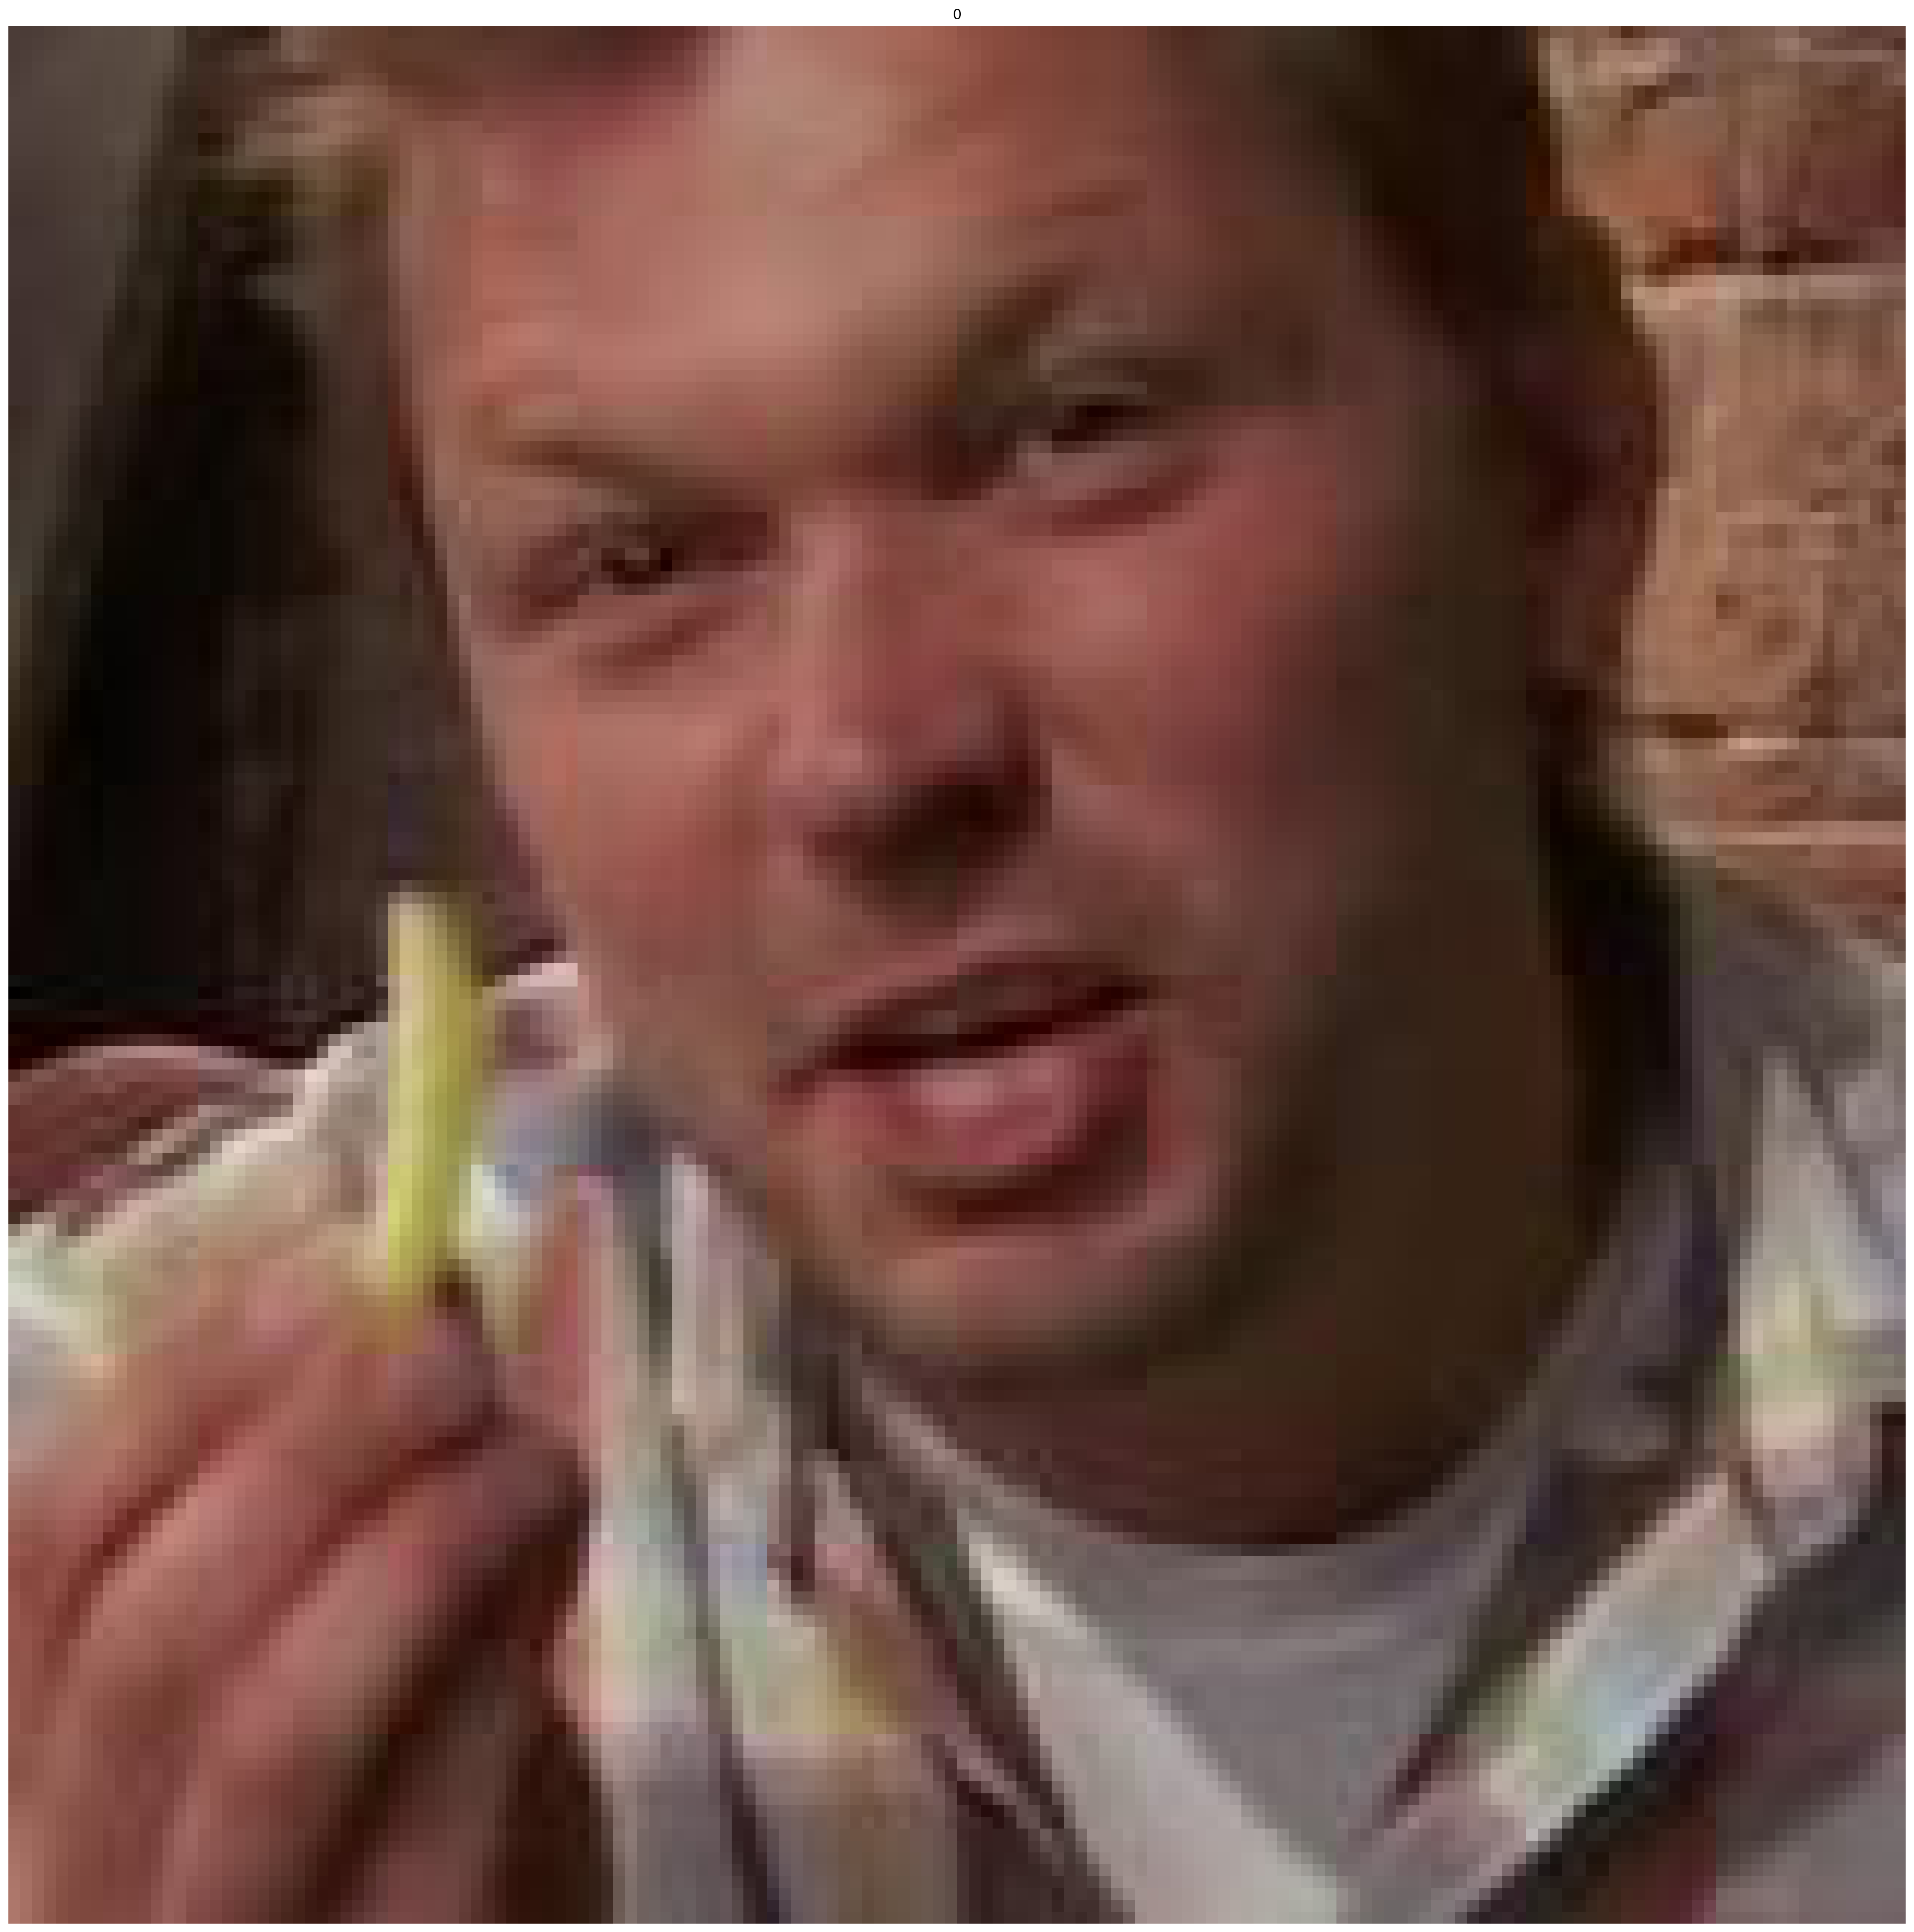

In [73]:
# A2ED.plot_face(300,"basel")
A2ED.plot_face(300,"real")

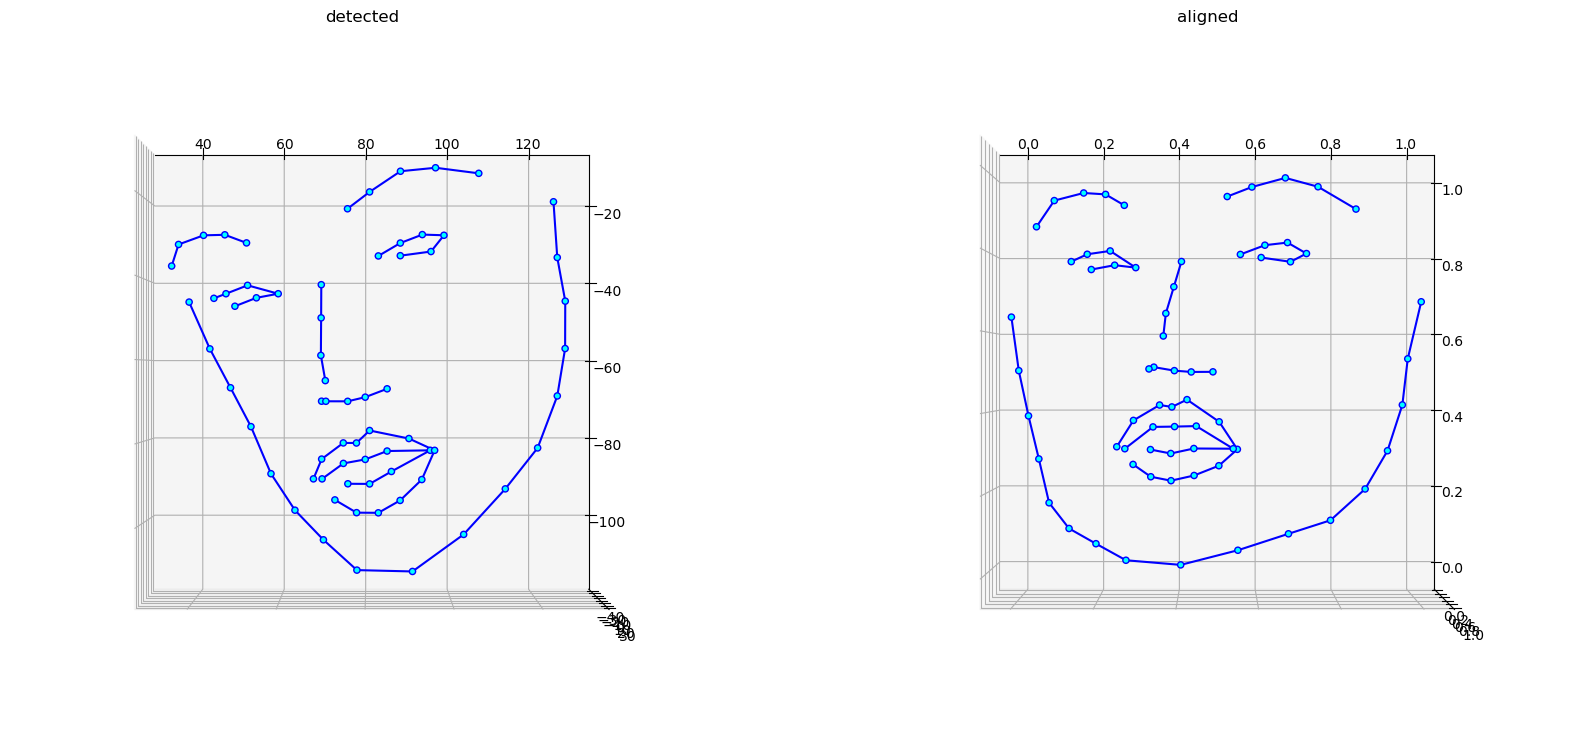

In [78]:
landmarks = torch.load(df.iloc[300]["landmarks"])
aligned = torch.load(df.iloc[300]["landmarks_aligned"])

smart_plot([landmarks*torch.tensor((1,-1,1)),aligned],["detected","aligned"],lines=FACE_LINES)


In [14]:
import time
for x in range(0,0):
    A2ED.plot_face(x,"basel")


In [15]:
import torch.nn as nn
import torch

class LipGenerator(nn.Module):
    def __init__(self,T=3):
        super().__init__()
        self.T=T
        #################################
        #########   lip net   ###########
        #################################

        self.convNet = nn.Sequential(
            nn.Conv2d(29, 64, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), #  29 x 16 x 1 => 32 x 8 x 1
            nn.LeakyReLU(0.02, True),
            nn.Conv2d(64, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 8 x 1 => 32 x 4 x 1
            nn.LeakyReLU(0.02, True),
            nn.Conv2d(128, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 4 x 1 => 64 x 2 x 1
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 64 x 2 x 1 => 128 x 1 x 1
            nn.LeakyReLU(0.2, True),
            
        )


        self.linearNet = nn.Sequential(
            nn.Linear(in_features = 128 , out_features=128, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 128, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=100, bias = True),
        )
        
        self.attentionConvNet = nn.Sequential( # b x subspace_dim x seq_len
            nn.Conv1d(100, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True)
        )
        self.attentionNet = nn.Sequential(
            nn.Linear(in_features = self.T, out_features=self.T, bias = True),   
            nn.Softmax(dim=1)
            )
        

    def forward(self,deepspeech):
        b = deepspeech.shape[0] # batchsize
        deepspeech = deepspeech.view(b * self.T, 1 , 16, 29) # b * seq_len x 1 x 16 x 29
        deepspeech = torch.transpose(deepspeech,1,3) #b* seq_len  x 29 x 16 x 1
        conved = self.convNet(deepspeech) # b * seq_len X 128 X 1 X 1
        
        conved = torch.reshape( conved, (b * self.T, 1, -1)) # b * seq_len X 1 X 128

        linear = self.linearNet(conved)[:,0,:]

        #################
        ### attention ###
        ################# 
        
        result_subspace = linear.view(b, self.T, 100) 
        result_subspace_T = torch.transpose(result_subspace, 1, 2) # b x subspace_dim x seq_len
        
        intermediate_expression = result_subspace_T[:,:,(self.T // 2):(self.T // 2) + 1] 
        
        
        att_conv_res = self.attentionConvNet(result_subspace_T) 
        
        attention = self.attentionNet(att_conv_res.view(b, self.T)).view(b, self.T, 1) # b x seq_len x 1
        
        result_subspace = torch.bmm(result_subspace_T, attention)
        return result_subspace.squeeze(),intermediate_expression.squeeze()


lip = LipGenerator()
for n in torch.utils.data.DataLoader(A2ED,batch_size=7,shuffle=False):
    
    lip(n['cur']['audio'])
    break    

In [16]:
# df=pd.read_csv('workspace/data.csv')
def get_loaders(args):
    
    
    A2ED_train = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="train"])[:args.data_size].reset_index(),T=args.seq_length)
    A2ED_test = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="test"])[:args.data_size].reset_index(),T=args.seq_length)
    
    dataloader_params = {
         "batch_size":args.batch_size,
        "shuffle":args.shuffle, 
        "num_workers":args.num_workers
    }
    if args.num_workers>0:
        dataloader_params["prefetch_factor"]=args.prefetch

    trainloader = torch.utils.data.DataLoader(A2ED_train,**dataloader_params)

    testloader = torch.utils.data.DataLoader(A2ED_test,**dataloader_params)
    
    return {"test":testloader,
           "train":trainloader}

In [17]:
import torch.optim as optim

def lr_decay(step, init_learning_rate = 1e-3, min_learning_rate = 1e-5, decay_rate = 0.9999):
    lr = ((init_learning_rate - min_learning_rate) *
          pow(decay_rate, step) +
          min_learning_rate)
    return lr

def build_model(args):
    model = LipGenerator(T=args.seq_length).to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.init_learning_rate)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: lr_decay(step,args.init_learning_rate,args.min_learning_rate,args.decay_rate)/args.init_learning_rate)
    if not args.pretrained == "":
        model.load_state_dict(torch.load(args.pretrained))

    return model,optimizer,scheduler

for x in range(10):
    print(lr_decay(x,0.1,0.0001,0.9))


0.1
0.09001
0.08101900000000001
0.07292710000000001
0.06564439000000001
0.05908995100000001
0.05319095590000001
0.04788186031000001
0.04310367427900001
0.03880330685110001


In [18]:
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [19]:
def train_and_test(model,optimizer,scheduler,loaders,args):
    running_loss = 0
    best_loss = -1
    step = 0
    torch.autograd.set_detect_anomaly(args.detect_anomaly)
    
    for epoch in tqdm(range(args.epochs)):  # loop over the dataset multiple times

        
        for split in ['train','test']:
            running_loss = 0

            if split == "train":
                model.train()
                loader = loaders['train']
            else:
                model.eval()
                loader=loaders['test']
            running_loss = 0
            running_mouth_loss =0
            for i, data in enumerate(tqdm(loader)):
                # get the inputs; data is a list of [inputs, labels]
#                 audio, ground_expression_vector, ground_shape_vector,idxes = [d.to(device) for d in data]
                
                step+=args.batch_size

                data = move_to(data,device)
            
                # forward + backward + optimize
                if split == "train":
                    audio_cat = torch.cat([data['prev']['audio'],data['cur']['audio'],data['nxt']['audio']])
                    output_expression_cat,intermediate_expression = model(audio_cat)

                    size = data['prev']['audio'].shape[0]
                    prev_output_expression = output_expression_cat[:size]
                    cur_output_expression = output_expression_cat[size:size*2]
                    nxt_output_expression = output_expression_cat[size*2:]
                    
                else:
                    with torch.no_grad():
                        
                        audio_cat = torch.cat([data['prev']['audio'],data['cur']['audio'],data['nxt']['audio']])
                        output_expression_cat,intermediate_expression = model(audio_cat)
                        
                        size = data['prev']['audio'].shape[0]
                        prev_output_expression = output_expression_cat[:size]
                        cur_output_expression = output_expression_cat[size:size*2]
                        nxt_output_expression = output_expression_cat[size*2:]

#                 if torch.isnan(audio_cat_gpu).any():
#                     print(f"contains nan: {output_expression_vector}")
#                     print(f"nan target: {ground_expression_vector} contains: {torch.isnan(ground_expression_vector).any()}max {ground_expression_vector.max()} min{ground_expression_vector.min()} ")
#                     print(f"nan input: {audio} contains: {torch.isnan(audio).any()} max {audio.max()} min{audio.min()}")

#                     print(f"prev target: {prev_ground_expression_vector} contains: {torch.isnan(prev_ground_expression_vector).any()}max {prev_ground_expression_vector.max()} min{prev_ground_expression_vector.min()} ")
#                     print(f"prev input: {prev_audio} contains: {torch.isnan(prev_audio).any()} max {prev_audio.max()} min{prev_audio.min()}")
#                     print(f"log_dict:{log_dict}")

#                     for n,p in model.named_parameters():
#                             print('===========\ngradient:{}\n----------\n{}'.format(n,p.grad))
#                             print('{} {}'.format(n,p.grad.max(),p.grad.min()))
#                             print('{} {}'.format(p.data.max(),p.data.min()))

#                     return

                # zero the parameter gradients
                optimizer.zero_grad()

                gt_expression_cur = data['cur']['expression'][:,args.seq_length//2,:]
                gt_expression_prev = data['prev']['expression'][:,args.seq_length//2,:]
                gt_expression_nxt = data['nxt']['expression'][:,args.seq_length//2,:]
            
            
                gt_expression_cat = torch.cat([gt_expression_prev,gt_expression_cur,gt_expression_nxt]).to(device)

                flat_intermediate_diff =  intermediate_expression - torch.cat([ data['prev']['expression'][:,args.seq_length//2,:], data['cur']['expression'][:,args.seq_length//2,:], data['nxt']['expression'][:,args.seq_length//2,:]])
                face_intermediate_diff = basel.get_expression(flat_intermediate_diff,2,add_means=False)
                
                #flat diff
                flat_diff = output_expression_cat - gt_expression_cat
                
                #face_diff
                face_diff = basel.get_expression(flat_diff,2,add_means=False)

                #temporal diffs
                temporal_prev_cur = (prev_output_expression - cur_output_expression) - (gt_expression_prev - gt_expression_cur)
                temporal_cur_next = (cur_output_expression - nxt_output_expression)  - (gt_expression_cur  - gt_expression_nxt)
                temporal_prev_next = (prev_output_expression - nxt_output_expression)- (gt_expression_prev - gt_expression_nxt)
                
                temporal_flat_cat = torch.cat([temporal_prev_cur,temporal_cur_next,temporal_prev_next])
                
                temporal_expression = basel.get_expression(temporal_flat_cat,2,add_means=False)
                
                
#                 if args.displacement>0:
#                     output_dlib = basel.get_expression(output_expression_vector,2,add_means=False)
#                     gt_dlib = basel.get_expression(ground_expression_vector,2,add_means=False)
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
                    
#                     if len(output_dlib.shape)==2:
#                         output_dlib = output_dlib[None,:,:]
#                         gt_dlib = gt_dlib[None,:,:]

                    
#                     idxs = list(range(68))
#                     idxs.append(idxs.pop(0))
                    
#                     mouth_idxs_norm = list(range(48, 68))
#                     mouth_idxs_shifted = list(mouth_idxs_norm)
#                     for disp in range(args.displacement):
#                         mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))
                    
#                     face_diff = (output_dlib - output_dlib[:,idxs,:]) - (gt_dlib - gt_dlib[:,idxs,:])
#                     mouth_diff = (output_dlib[:,mouth_idxs_norm,:] - output_dlib[:,mouth_idxs_shifted,:]) -( gt_dlib[:,mouth_idxs_norm,:] - gt_dlib[:,mouth_idxs_shifted,:])

                   
#                 else:
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
#                     if len(output_diff.shape)==2:
#                         face_diff = face_diff[None,:,:]
#                     mouth_diff = face_diff[:,48:68,:]
                    

                #300 is batch size
                loss_dict = {}
                if args.metric=="L1": 
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.abs().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].abs().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.abs().mean()
                    
                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.abs().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.abs().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.abs().mean()
                    

                if args.metric == "L2":
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.square().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].square().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.square().mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.square().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.square().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.square().mean()
             

                if args.metric == "RMS":
                    
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.square().sqrt().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].square().sqrt().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.square().sqrt().mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.square().sqrt().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.square().sqrt().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.square().sqrt().mean()
                 
                
                loss = loss_dict['loss'] = sum(loss_dict.values())
                running_loss+=loss.detach()/len(loader)

                log_dict = {k:v.detach() for k,v in loss_dict.items()}
                log_dict['epoch'] = epoch
                
                
                if split=="train":
                    if i%args.retrieval_train_step==0 and epoch>=args.warmup_epochs:
                        retrieval = []
                        targets = []
                        predicted = []
                        with torch.no_grad():
                            #we use the 1th idx of cur, because this resembles the target idx
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:30],data['cur']['idx'][args.seq_length//2][:30])):
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                predicted.append(pred_sort[0])
                                retrieval.append((pred_sort.index(frame_idx))/len(video_gt))
                            print(f"train predicted: {predicted} \ntarget: {targets}")
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)

                    loss.backward()
                    if not args.clip is None:
                        torch.nn.utils.clip_grad_value_(model.parameters(), args.clip)

#                         if i%args.check_gradients==0:
#                             for n,p in model.named_parameters():
#                                 print('===========\ngradient:{}\n----------\n{} {} '.format(n,p.grad.max(),p.grad.min()))
#                                 print('===========\weigth:----------\n')
#                                 print('{} {}'.format(p.data.max(),p.data.min()))
#                             print('\n\n\n')


                    optimizer.step()
                    if args.use_wandb:
                        wandb.log(log_dict,step=step)
                else:
                    if i%args.retrieval_test_step==0 and epoch>args.warmup_epochs:
                        with torch.no_grad():
                            retrieval = []
                            targets = []
                            predicted = []
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:50],data['cur']['idx'][args.seq_length//2][:50])):
                                
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                retrieval.append(pred_sort.index(frame_idx)/len(video_gt))
                                predicted.append(pred_sort[0])
                            print(f"test predicted: {predicted} \ntargets: {targets}")
                            
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)
                    if args.use_wandb:
                        wandb.log({"test_"+k:v for k,v in log_dict.items()},step=step)
            
            
            if split=="test":
                print(f"outputs max  {cur_output_expression.max(dim=1)[0][:5]} min {cur_output_expression.min(dim=1)[0][:5]}  mean {cur_output_expression.mean(dim=1)[:5]}")
                print(f"ground max  {gt_expression_cur.max(dim=1)[0][:5]} min {gt_expression_cur.min(dim=1)[0][:5]} mean {gt_expression_cur.mean(dim=1)[:5]}")

                print(f"eval [{epoch} {args.epochs}]: loss: {running_loss/(len(loader)*300)} mouth {running_mouth_loss/(len(loader)*300)}")
                if epoch>args.save_after: torch.save(model.state_dict(), 'checkpoints/training/{}{}.pt'.format(epoch, args.name))

                if best_loss==-1 or best_loss > running_loss:
                    best_loss = running_loss
                    if epoch>args.save_after:torch.save(model.state_dict(), 'checkpoints/training/best_{}.pt'.format(args.name))
                    print("new best")
            
            del loss_dict
            
        scheduler.step()
        print(f"new learning rate: {optimizer.param_groups[0]['lr']}")
    print('Finished Training')

In [20]:
def run(args):
    model,optimizer,scheduler = build_model(args)
    loaders = get_loaders(args)
    if args.use_wandb:
        wandb.init(project="lipgeneration",config=args,name=args.name)
        wandb.watch(model,log_freq=10)

    train_and_test(model,optimizer,scheduler,loaders,args)

In [21]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()

args.num_workers = 0
args.prefetch = 2
args.shuffle =True

args.batch_size = 400
args.full_multiplier = 1
args.mouth_multiplier = 10
args.flat_multiplier = 1
args.temporal_flat_multiplier = 1
args.temporal_face_multiplier = 3
args.intermediate_multiplier = 1




args.retrieval_train_step = 2000
args.retrieval_test_step  = 250


args.clip = 1
args.detect_anomaly = False

args.check_gradients = 1000
args.metric = "L2"
args.epochs=1000
args.data_size = -1
args.print_step = 1000
args.displacement = 1
args.warmup_epochs = 1
args.save_after = 5
args.seq_length = 3

args.init_learning_rate = 1e-3
args.min_learning_rate = 4e-5
args.decay_rate = 0.99
args.pretrained = "" #"checkpoints/training/10L2-0.0004->-1.pt"
args.extra_name = ""
args.use_wandb = True
args.name = f"{args.metric}-{args.init_learning_rate}-{args.displacement}{args.extra_name}->{args.data_size}"






In [ ]:
run(args)

init dataset
init dataset


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5222 [00:00<?, ?it/s]

In [ ]:
model,_,_ = build_model(args)

In [ ]:
idx = 800
audio, ground_expression_vector,ground_shape_vector,_idx = A2ED.__getitem__(idx,False)
ground_expression_vector = ground_expression_vector.to(device)
ground_shape_vector = ground_shape_vector.to(device)
# forward + backward + optimize
output_expression_vector = model(audio[None,:,:].to(device))

face = basel.get_face(ground_shape_vector,output_expression_vector)
target_face = basel.get_face(ground_shape_vector,ground_expression_vector)

smart_plot([face.detach().cpu(),target_face.cpu(),],["generated","target"],lines=FACE_LINES)

A2ED.plot_face(idx,"real")